In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('routes.csv', header=None)

In [3]:
df.columns= ['Airline', 'Airline_ID', 'Source', 'Source_ID', 'Destination', 'Destination_ID', 'Codeshare', 'Stops', 'Equipment']
df

,Airline,Airline_ID,Source,Source_ID,Destination,Destination_ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,NaN,0,SF3
67659,ZM,19016,DME,4029,FRU,2912,NaN,0,734
67660,ZM,19016,FRU,2912,DME,4029,NaN,0,734
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734


# Preprocessing

In [4]:
# Convert codeshare to a binary feature
df['Codeshare'] = df['Codeshare'].apply(lambda x: 1 if x == 'Y' else 0)

In [5]:
# Handle missing values, for example, fill NaN with 0 or appropriate value
df.fillna(0, inplace=True)

# Feature Engineering

In [6]:
# Convert to OHE for ML later on
df_encoded = pd.get_dummies(df, columns=['Airline', 'Source', 'Destination', 'Equipment'])

# Create Graph

In [7]:
G = nx.from_pandas_edgelist(df, source='Source_ID', target='Destination_ID')
print(G.number_of_edges())

19205


In [8]:
def common_neighbors(G, node_pair):
    return len(list(nx.common_neighbors(G, node_pair[0], node_pair[1])))

node_pairs = list(nx.non_edges(G))  # potential new edges
features = [[common_neighbors(G, pair)] for pair in node_pairs]
labels = [1 if G.has_edge(*pair) else 0 for pair in node_pairs]  # 1 if link exists, else 0

In [9]:
def directed_common_neighbors(G, u, v):
    # Shared successors
    successors_u = set(G.successors(u))
    successors_v = set(G.successors(v))
    common_successors = len(successors_u & successors_v)

    # Shared predecessors
    predecessors_u = set(G.predecessors(u))
    predecessors_v = set(G.predecessors(v))
    common_predecessors = len(predecessors_u & predecessors_v)

    return common_successors + common_predecessors

In [10]:
from random import sample
positive_pairs = [(u, v) for u, v in G.edges()]
positive_labels = [1] * len(positive_pairs)  # Label 1 for existing edges
negative_pairs = [(u, v) for u, v in nx.non_edges(G) if not G.has_edge(v, u)]
negative_pairs = sample(negative_pairs, len(positive_pairs))  # Randomly sample non-edges
negative_labels = [0] * len(negative_pairs)  # Label 0 for non-existing edges

In [11]:
all_pairs = positive_pairs + negative_pairs
all_labels = positive_labels + negative_labels

# Optionally, shuffle the dataset to ensure a random mix of positives and negatives
from sklearn.utils import shuffle
all_pairs, all_labels = shuffle(all_pairs, all_labels)

In [12]:
len(features)

5536908

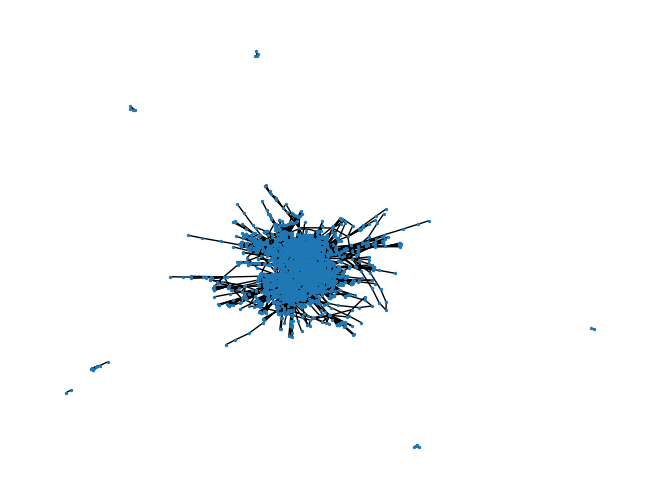

In [13]:
nx.draw(G, node_size = 2)

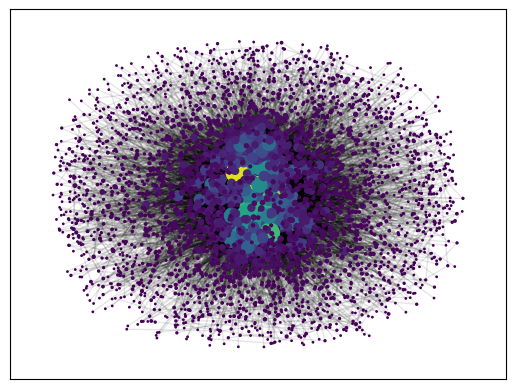

In [14]:
# Use spring layout
pos = nx.spring_layout(G, k=0.1, iterations=20)

# Draw nodes with node size determined by degree
node_size = [len(list(G.neighbors(n))) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_size, cmap=plt.cm.viridis)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)

# If you want to add labels to the most important nodes only:
# important_nodes = [node for node, degree in dict(G.degree()).items() if degree > 5]  # Adjust threshold as needed
# labels = {node: node for node in important_nodes}
# nx.draw_networkx_labels(G, pos, labels=labels, font_size=5)

plt.show()

# Feature Extraction

In [15]:
G = nx.from_pandas_edgelist(df, source='Source_ID', target='Destination_ID', create_using=nx.DiGraph())

def extract_features(graph, node):
    features = {
        'degree': graph.degree(node),
        'in_degree': graph.in_degree(node),
        'out_degree': graph.out_degree(node),
        'clustering_coefficient': nx.clustering(graph, node),
        'page_rank': nx.pagerank(graph).get(node)
    }
    return features

columns = ['degree', 'in_degree', 'out_degree', 'clustering_coefficient', 'page_rank']
features_df = pd.DataFrame(index=G.nodes(), columns=columns)

# Pre-compute PageRank for the entire graph to avoid recalculating it for each node
page_rank = nx.pagerank(G)

# Fill in the features for each node
for node in G.nodes():
    features_df.loc[node, 'degree'] = G.degree(node)
    features_df.loc[node, 'in_degree'] = G.in_degree(node)
    features_df.loc[node, 'out_degree'] = G.out_degree(node)
    features_df.loc[node, 'clustering_coefficient'] = nx.clustering(G, node)
    features_df.loc[node, 'page_rank'] = page_rank[node]


In [16]:
def create_feature_vector(graph, u, v, page_rank):
    features_u = [
        graph.degree(u),
        graph.in_degree(u),
        graph.out_degree(u),
        nx.clustering(graph, u),
        page_rank[u]
    ]
    features_v = [
        graph.degree(v),
        graph.in_degree(v),
        graph.out_degree(v),
        nx.clustering(graph, v),
        page_rank[v]
    ]
    common_neighbors = directed_common_neighbors(graph, u, v)
    return features_u + features_v + [common_neighbors]

# Assuming 'all_pairs' contains all node pairs (u, v) you're interested in
features = [create_feature_vector(G, u, v, page_rank) for u, v in all_pairs]


In [17]:
from sklearn.model_selection import train_test_split

# Assuming 'features' is your feature matrix and 'labels' is your labels vector
X_train, X_test, y_train, y_test = train_test_split(features, all_labels, test_size=0.3, random_state=42)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, fbeta_score

lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)
y_pred = lrmodel.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
lr_report = classification_report(y_test, y_pred, output_dict=True)
F0_5 = fbeta_score(y_test, y_pred, beta=0.5)
print("The overall F-0.5 score for logistic regression is",F0_5)

Accuracy: 0.9112210361884926
ROC-AUC Score: 0.911309057048376
The overall F-0.5 score for logistic regression is 0.9415957691423316


In [35]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest
rfmodel.fit(X_train, y_train)
rf_pred = rfmodel.predict(X_test)
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_pred))
rf_report = classification_report(y_test, rf_pred, output_dict=True)
F0_5 = fbeta_score(y_test, rf_pred, beta=0.5)
print("The overall F-0.5 score for random forest is",F0_5)

Accuracy: 0.9661546472272846
ROC-AUC Score: 0.9661463795093268
The overall F-0.5 score for random forest is 0.9632034632034633


In [33]:
from sklearn.svm import SVC

svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, svm_pred))
svm_report = classification_report(y_test, svm_pred, output_dict=True)
F0_5 = fbeta_score(y_test, svm_pred, beta=0.5)
print("The overall F-0.5 score for Support Vector Classifier is",F0_5)

Accuracy: 0.9023691746940901
ROC-AUC Score: 0.9024436048888366
The overall F-0.5 score for Support Vector Classifier is 0.9269175654272569


In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, knn_pred))
knn_report = classification_report(y_test, knn_pred, output_dict=True)
F0_5 = fbeta_score(y_test, knn_pred, beta=0.5)
print("The overall F-0.5 score for KNN is",F0_5)

Accuracy: 0.936301310422633
ROC-AUC Score: 0.9362986111383075
The overall F-0.5 score for KNN is 0.9355340477013481


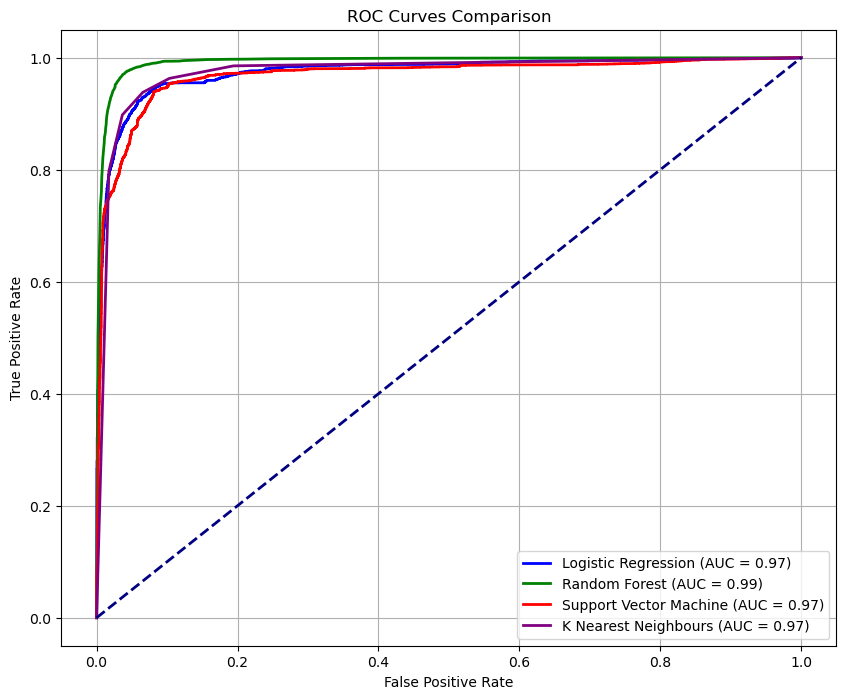

In [38]:
from sklearn.metrics import roc_curve, auc
pred_probs_1 = lrmodel.predict_proba(X_test)[:, 1] 
pred_probs_2 = rfmodel.predict_proba(X_test)[:, 1] 
pred_probs_3 = svm_model.predict_proba(X_test)[:, 1] 
pred_probs_4 = knn_model.predict_proba(X_test)[:, 1] 

fpr1, tpr1, _ = roc_curve(y_test, pred_probs_1)
fpr2, tpr2, _ = roc_curve(y_test, pred_probs_2)
fpr3, tpr3, _ = roc_curve(y_test, pred_probs_3)
fpr4, tpr4, _ = roc_curve(y_test, pred_probs_4)

# Compute the AUC (Area under the Curve) if needed
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)

plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f'Logistic Regression (AUC = {auc1:.2f})', color='blue', lw=2)
plt.plot(fpr2, tpr2, label=f'Random Forest (AUC = {auc2:.2f})', color='green', lw=2)
plt.plot(fpr3, tpr3, label=f'Support Vector Machine (AUC = {auc3:.2f})', color='red', lw=2)
plt.plot(fpr4, tpr4, label=f'K Nearest Neighbours (AUC = {auc4:.2f})', color='purple', lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

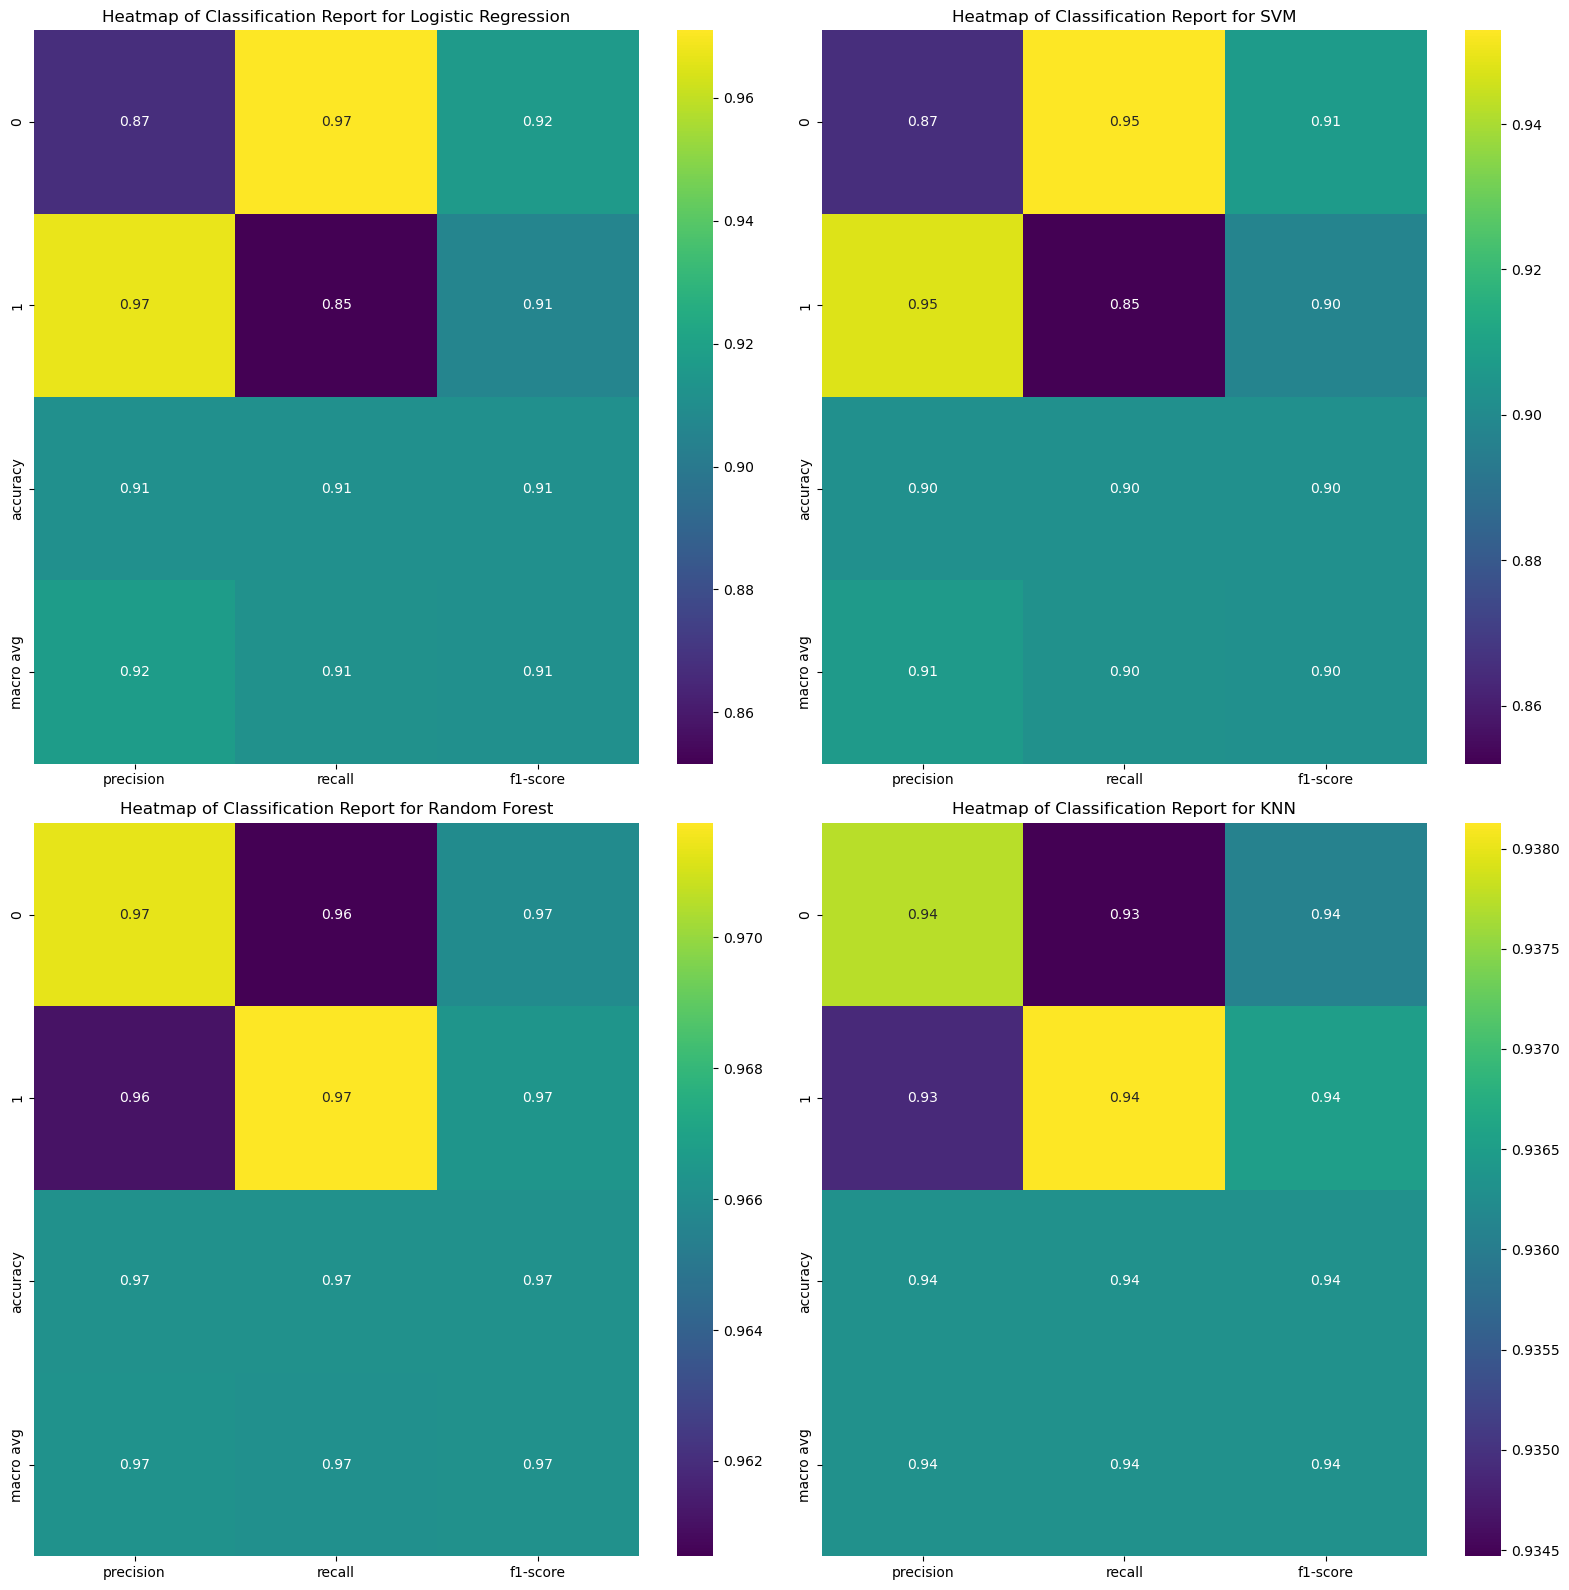

In [39]:
report = {'Logistic Regression': lr_report, 'SVM': svm_report, 'Random Forest': rf_report, 'KNN': knn_report}

import seaborn as sns

fig, axs= plt.subplots(figsize = (16,16), nrows = 2, ncols=2)
axs = axs.flatten()

for idx, (name, rep) in enumerate(report.items()):
    # Convert the classification report into a DataFrame
    report_df = pd.DataFrame(rep).transpose()
    # Remove the 'support' column if not needed for visual clarity
    report_df = report_df.drop(columns=['support'], errors='ignore')

    # Plot the heatmap
    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, fmt=".2f", cmap="viridis", ax=axs[idx])
    axs[idx].set_title(f"Heatmap of Classification Report for {name}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [23]:
df['Codeshare'] = df['Codeshare'].apply(lambda x: 1 if x == 'Y' else 0)
df['Stops'] = df['Stops'].astype(int)
airlines_encoded = pd.get_dummies(df['Airline'], prefix='Airline')
# Split the 'equipment' column into separate rows
equipment_list = df['Equipment'].str.split(' ').apply(pd.Series, 1).stack()
equipment_list.index = equipment_list.index.droplevel(-1)
equipment_list.name = 'Equipment_Split'

# Drop the original 'Equipment' column to avoid conflict
df.drop('Equipment', axis=1, inplace=True)

# Join the expanded equipment list with the original DataFrame
df = df.join(equipment_list)

# Now, perform one-hot encoding on the split equipment codes
equipment_encoded = pd.get_dummies(df['Equipment_Split'], prefix='Equipment')


C:\Users\Khojasteh Mirza\AppData\Local\Temp\ipykernel_19984\2286014298.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  equipment_list = df['Equipment'].str.split(' ').apply(pd.Series, 1).stack()


In [24]:
# Combine all the features into a single DataFrame
features_df = features_df.join(df['Codeshare'])
features_df = features_df.join(df['Stops'])
features_df = features_df.join(airlines_encoded)
features_df = features_df.join(equipment_encoded)

# You might need to fill NaN values that arose from joining operations
features_df.fillna(0, inplace=True)  # This fills NaN values with 0, which may or may not be appropriate depending on context

C:\Users\Khojasteh Mirza\AppData\Local\Temp\ipykernel_19984\1464258235.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df.fillna(0, inplace=True)  # This fills NaN values with 0, which may or may not be appropriate depending on context


Text(0.5, 1.0, 'Box Plot of Degree')

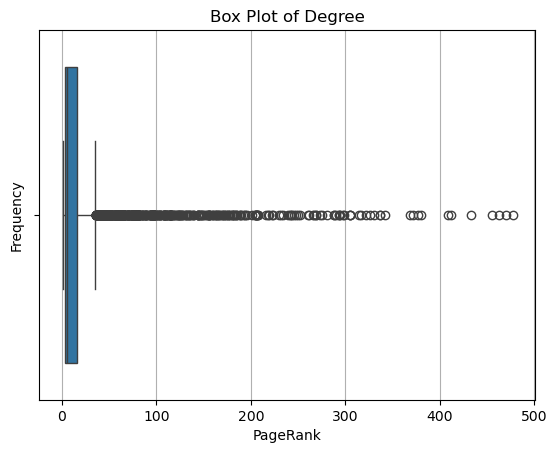

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numerical features
features_df['page_rank'].hist(bins=30)
plt.title('Distribution of PageRank')
plt.xlabel('PageRank')
plt.ylabel('Frequency')

# Box plots for outlier detection
sns.boxplot(x=features_df['degree'])
plt.title('Box Plot of Degree')

Text(0.5, 1.0, 'Pagerank vs Degree')

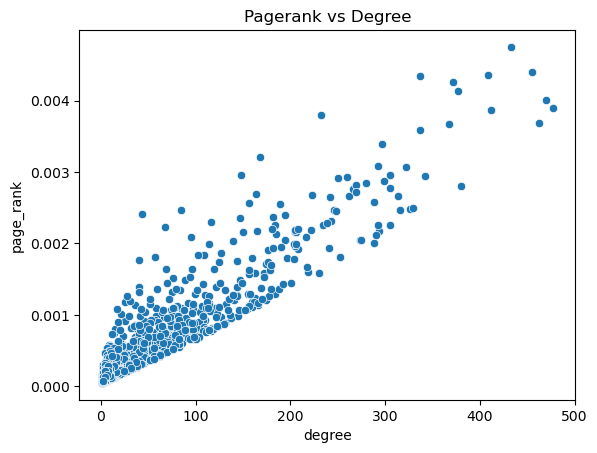

In [26]:
sns.scatterplot(data=features_df, x = 'degree', y='page_rank')
plt.title('Pagerank vs Degree')

Text(0, 0.5, 'Frequency')

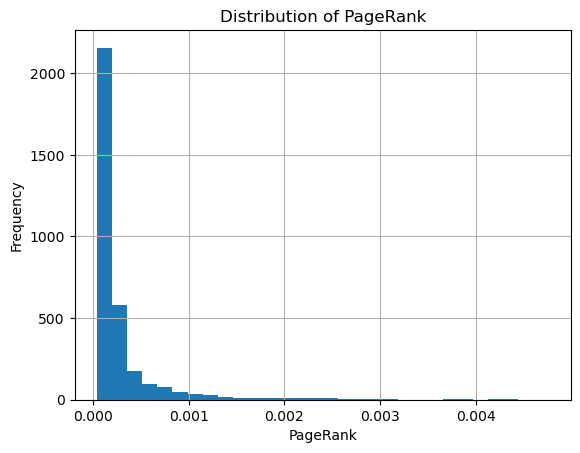

In [27]:
features_df['page_rank'].hist(bins=30)
plt.title('Distribution of PageRank')
plt.xlabel('PageRank')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Box Plot of Degree')

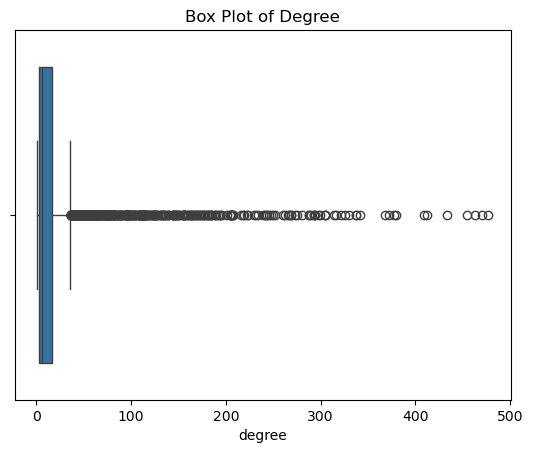

In [28]:
sns.boxplot(x=features_df['degree'])
plt.title('Box Plot of Degree')